# Summary

Solve for the trajectory of a single erosion ray – by integrating Hamilton's equations from an initial vertical velocity condition that mimics a constant slip "normal fault" boundary. 

The properties of this solution are analyzed graphically in some detail. Ray velocity vector and normal slowness covector components are examined as they vary along the trajectory, as are the properties of the corresponding metric tensor. Where possible, some investigation of the equivalent geodesic equation is also carried out along the ray.

### Preliminaries

In [1]:
# Specify the parameter files for the job
import os
if 'GME_NB_PR' not in os.environ.keys():
#     pr_filenames = ['TimeInvariant_sinbeta_ramp_eta1p5_ratio0p5_xiv30', 'OneRay_eta1plus']
#     pr_filenames = ['TimeInvariant_sinbeta_ramp_eta1p5_ratio0p5_xiv60', 'OneRay_eta1plus']
#     pr_filenames = ['TimeInvariant_sinbeta_ramp_eta1p5_ratio0p5_xiv90', 'OneRay_eta1plus']
    
#     pr_filenames = ['TimeInvariant_sinbeta_ramp_eta1p0_ratio0p5_xiv100', 'OneRay_eta1']

#     pr_filenames = ['TimeInvariant_sinbeta_ramp_eta0p5_ratio0p5_xiv30', 'OneRay_eta1minus']
#     pr_filenames = ['TimeInvariant_sinbeta_ramp_eta0p5_ratio0p5_xiv60', 'OneRay_eta1minus']
    pr_filenames = ['TimeInvariant_sinbeta_ramp_eta0p5_ratio0p5_xiv80', 'OneRay_eta1minus']
#     pr_filenames = ['TimeInvariant_sinbeta_ramp_eta0p5_ratio0p5_xiv100', 'OneRay_eta1minus']
else:
    pr_filenames = eval(os.environ['GME_NB_PR'])
    
# Import Sympy and Numpy and set up latex inline & pretty dict printing
import sympy as sy, numpy as np
sy.init_printing(pretty_print=True,wrap_line=True)
from sympy import simplify, Matrix, Eq, sin,cos,tan,sec, Rational, sqrt, solve
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint

# Import Geomorphysics library functions, classes
from gmplib.utils import numify, export_results, e2d
from gmplib.save import create_directories, export_plots
from gmplib.parameters import import_parameters, Parameters

# Import GME classes and do a wildcard (!) import of all GME symbol definitions
from gme.symbols import *
from gme.equations import Equations, EquationSubset
from gme.ode_raytracing import OneRaySolution
from gme.plot import OneRayPlots

# Decide where we're working and thus where to find the job parameter files
#   -  use the GME_WORKING_PATH environment variable if it's defined
#   -  otherwise, deduce that we're working in the GME notebook dir
if 'GME_WORKING_PATH' in os.environ.keys():
    working_path = os.environ['GME_WORKING_PATH']
    print(f'Fetching working path from environment variable GME_WORKING_PATH = {working_path}')
else:
    from gmplib.utils import get_pkg_path
    import gme
    working_path = get_pkg_path(gme, dirname='')
    print(f'Deducing working path from GME package location = {working_path}')
    del gme
    
# Set the path to the parameter files for this nb and report
pr_path = os.path.join(working_path,'Parameters','RayTracing')
pr_path, pr_filenames

Deducing working path from GME package location = /Users/colinstark/Projects/GME


('/Users/colinstark/Projects/GME/Parameters/RayTracing',
 ['TimeInvariant_sinbeta_ramp_eta0p5_ratio0p5_xiv80', 'OneRay_eta1minus'])

In [2]:
# Read and combine the default and job parameter files, and report

parameters_dict,_ = import_parameters([pr_path], [os.path.join('..','defaults'), *pr_filenames])
pr = Parameters(parameters_dict, evaluations={}, sequence=())
[pp(psubobj.__dict__) for psubobj in (pr.job, pr.model, pr.solve, pr.resolve, pr.plot, pr.save)];

{   'debug': False,
    'group_name': 'OneRaySolutions',
    'short_name': 'oneray',
    'subtitle': '',
    'title': 'Single ray solution on top of time-invariant parameters',
    'verbose': True,
    'very_verbose': False}
{   'beta_type': 'sin',
    'do_geodesic': False,
    'eta': 1/2,
    'h_0': 1/2,
    'ibc_type': 'concave-up',
    'kappa_h': 3/2,
    'mu': 1/4,
    't_xiv0_list': None,
    'varepsilon': 1/1000,
    'varphi_0': 300,
    'varphi_type': 'ramp',
    'x_1': 1,
    'x_h': 1,
    'x_sigma': 0.01,
    'xiv_0': 80}
{   'choice': 'Hamilton',
    'do_dense': True,
    'do_geodesic': True,
    'do_ic': False,
    'do_ip': False,
    'do_vb': False,
    'ic_res': 31,
    'ip_res': 101,
    'method': {'Hamilton': 'DOP853', 'geodesic': 'LSODA'},
    'ray_n_t': 301,
    't_distribn': 3,
    't_end': 0.0115,
    'vb_res': 101}
{   'do_eliminate_caustics': True,
    'n_isochrones': 30,
    'spline_order': 3,
    't_isochrone_max': 0.01,
    'tolerance': None}
{   'ang_x_limits':

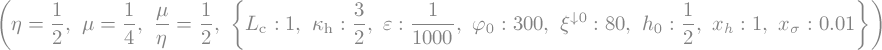

In [3]:
# Create a dict of the key physics parameters to be used in substitutions

sub = {
        x_1: pr.model.x_1, 
        varepsilon: pr.model.varepsilon, 
        varphi_0: pr.model.varphi_0,
        xiv_0: pr.model.xiv_0,
        kappa_h: pr.model.kappa_h,
        h_0: pr.model.h_0,
        x_sigma: pr.model.x_sigma,
        x_h: pr.model.x_h
}
Eq(eta,pr.model.eta), Eq(mu,pr.model.mu), Eq(mu/eta,pr.model.mu/pr.model.eta), sub

# Equations

Derive the GME equation set (using Sympy) for a specific erosion model.

In [4]:
gmeq = Equations( eta=pr.model.eta, 
                  mu=pr.model.mu, 
                  beta_type=pr.model.beta_type, 
                  varphi_type=pr.model.varphi_type, 
                  ibc_type=pr.model.ibc_type,
                  do_idtx=pr.plot.do_huygens_wavelets,
                  do_geodesic=pr.solve.do_geodesic & False, 
                  parameters=sub )

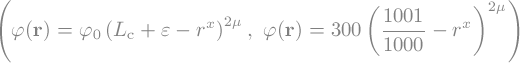

In [5]:
gmeq.varphi_rx_eqn, gmeq.varphi_rx_eqn.subs(sub)

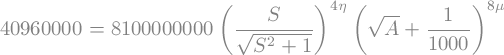

In [6]:
varphi_A_eqn_ = gmeq.xi_varphi_beta_eqn.subs(e2d(gmeq.varphi_rx_eqn)) \
                .subs({rx:x_1-x, xi:xiv_0})
if pr.model.beta_type=='sin':
    varphi_A_eqn_ = varphi_A_eqn_.subs({abs(sin(beta)):tan(beta)/sqrt(1+tan(beta)**2)})
varphi_A_eqn_ = varphi_A_eqn_\
                    .subs({(tan(beta)):S})\
                    .subs({x:A**Rational(1,2)}).subs(sub)
if pr.model.beta_type=='sin':
    varphi_A_eqn_ = Eq(varphi_A_eqn_.lhs**4, varphi_A_eqn_.rhs**4)
varphi_A_eqn_

In [7]:
# S_A_solns = sy.solve(varphi_A_eqn_, S)
# S_A_ = [soln for soln in S_A_solns if sy.re(soln.subs({A:1}))>0][0]
# sy.plot(S_A_, (A,0.00001,1), xscale='log',yscale='log')
# S_A_

# Integration

Integrate Hamilton's equations in $(\mathbf{r}, \mathbf{\widetilde{p}})[t]$ for a given vertical component of the erosion rate (initial condition) equivalent to a constant vertical velocity (boundary condition). In other words, given a value for vertical slip rate $\xi^{\downarrow}$ at the boundary at $x=0$, where the initial ray position is $\left.(r^x, r^z)\right|_{t=0} = (0,0)$, specify the initial value of the vertical component of the normal-slowness covector $p_z[t=0] = \left.-1/\xi^{\downarrow}\right|_{x=0}$.  The horizontal component of the initial covector $p_x[t=0]$ is computed by calculating the surface gradient $\left.\tan\beta\right|_{x=0}$ from the erosion model and then using $-p_x/p_z = \tan\beta$.

Various ODE quadrature methods provided by SciPy's `solve_ivp` function can be used here, but it appears that  "DOP853" (explicit Runge-Kutta method of order 8(5,3)  with dense output of order 7) is the best pick – it's fairly speedy but also robust. All the other quadrature methods (straightforward Runge-Kutta (RK45 or RK23), "Radau" (implicit Runge-Kutta method of the Radau IIA family of order 5), "BDF" (implicit multi-step variable-order (1 to 5) method based on a backward differentiation formula for the derivative approximation), "LSODA" (Adams/BDF method with automatic stiffness detection and switching) cause problems for computation of ray acceleration using the Christoffel symbols (one step away from solving the ray trajectory using the geodesic equation).

Test timings and notes for `TimeInvariant_sinbeta_ramp_eta0p25_xiv30`:
  - DOP853:  80ms
      - also works well for geodesic computations
  - Radau:   90ms
      - oscillatory problems with geodesic computation of ray acceleration (in $\dot{v}^z$)
  - RK45:   75ms
      - oscillatory problems with geodesic computation of ray acceleration (in $\dot{v}^z$)
  - RK23:   75ms
      - oscillatory problems with geodesic computation of ray acceleration (in $\dot{v}^z$)
  - BDF:   95ms
      - wild variability problems with geodesic computation of ray acceleration (in $\dot{v}^z$)
  - LSODA:   95ms
      - fairly wild variability problems with geodesic computation of ray acceleration (in $\dot{v}^z$)

In [8]:
pr.solve.choice, pr.solve.method[pr.solve.choice]

('Hamilton', 'DOP853')

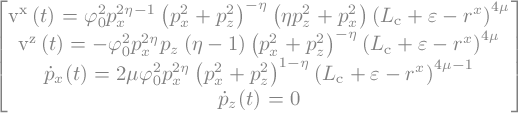

In [9]:
gmeq.hamiltons_eqns

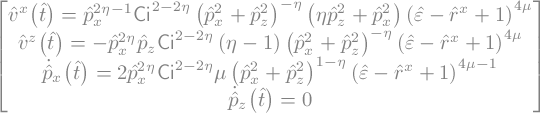

In [10]:
gmeq.hamiltons_ndim_eqns

Create an instance of the ODE solution object.

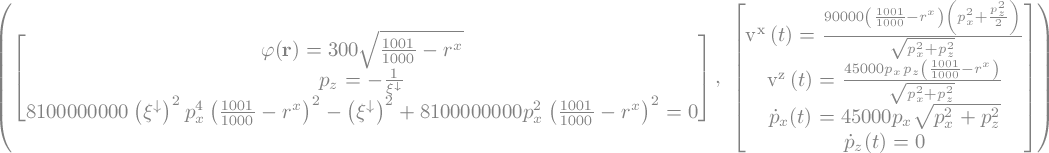

In [11]:
gmeq_subset = EquationSubset(gmeq, sub, do_ndim=False) 
Matrix([
    gmeq_subset.varphi_rx_eqn, 
    gmeq_subset.pz_xiv_eqn,
    gmeq_subset.poly_px_xiv_eqn,
     #gmeq.geodesic_eqns
#  gmeq.px_initial_eqn, gmeq.pz_initial_eqn
]), Matrix([gmeq_subset.hamiltons_eqns])

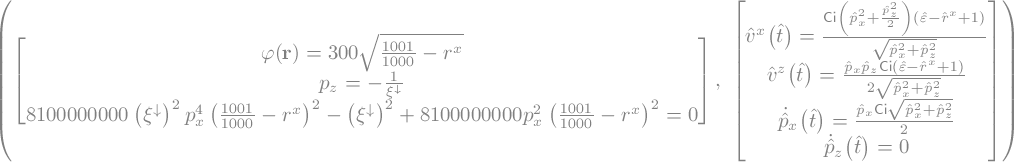

In [12]:
gmeq_ndim_subset = EquationSubset(gmeq, sub, do_ndim=True) 
Matrix([
    gmeq_ndim_subset.varphi_rx_eqn, 
    gmeq_ndim_subset.pz_xiv_eqn,
    gmeq_ndim_subset.poly_px_xiv_eqn,
     #gmeq.geodesic_eqns
#  gmeq.px_initial_eqn, gmeq.pz_initial_eqn
]), Matrix([gmeq_ndim_subset.hamiltons_eqns])

In [13]:
gmes = OneRaySolution( gmeq_subset, parameters=sub, 
                       t_end=pr.solve.t_end, t_distribn=pr.solve.t_distribn, 
                       n_t=pr.solve.ray_n_t,
                       choice=pr.solve.choice, 
                       method=pr.solve.method[pr.solve.choice],
                       do_dense=pr.solve.do_dense )

Solve Hamilton's ODEs using DOP853 method of integration


Set of initial conditions for the ray.

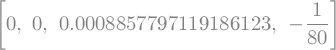

In [14]:
gmes.initial_conditions()

Show the form of the ray tracing Hamilton's equations given the model parameters.

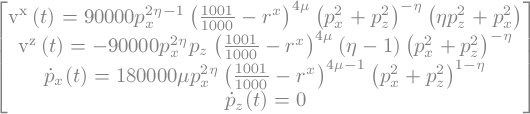

In [15]:
gmeq.hamiltons_eqns.subs(sub).subs({-pz:sy.Abs(pz)})

Perform integration of the coupled ODEs.  If "Success" returns "False", it doesn't mean integration fails, but rather indicates a ?minor issue in the numerics. The more important return value here is "rx_final", which needs to be ≈1, i.e., that the ray has been integrated across (almost) the whole domain.

In [16]:
gmes.solve()
print('Message: {}\nSuccess? {}\nStatus: {}\nt_final: {}\nrx_final: {}'
      .format(gmes.solns[0].message, gmes.solns[0].success,
              gmes.solns[0].status, gmes.solns[0].t[-1], gmes.solns[0].y[0][-1]) )

Message: A termination event occurred.
Success? True
Status: 1
t_final: 0.005598479407407409
rx_final: 0.998386447980653


Process the above output, which takes the form of time series of positions $\{\mathbf{r}\}$ and front normal slownesses  $\{\mathbf{\widetilde{p}}\}$, into various arrays.

In [17]:
gmes.postprocessing(spline_order=pr.resolve.spline_order)

# Plots

Visualize ray behavior and properties of the ray, mainly as a function of horizontal distance traversed.

## Set up

In [18]:
gr = OneRayPlots()

In [19]:
prefix = ('_').join([pr.job.short_name, gmeq.beta_type+'beta', gmeq.varphi_type.replace('-','')])

suffix = f'_eta{float(sy.N(gmeq.eta))}'
suffix += f'_ratio{float(sy.N(gmeq.mu/gmeq.eta))}' # if gmeq.mu!=Rational(1,2) else ''
suffix += f'_xiv{float(sy.N(gmes.parameters[xiv_0])):1.0f}'
suffix = (suffix if pr.model.varphi_type=='ramp' \
            else suffix+f'_xh{float(gmes.parameters[x_h]):1.1f}').replace('.','p')

job_name = prefix+suffix
job_name

'oneray_sinbeta_ramp_eta0p5_ratio0p5_xiv80'

## Profiles

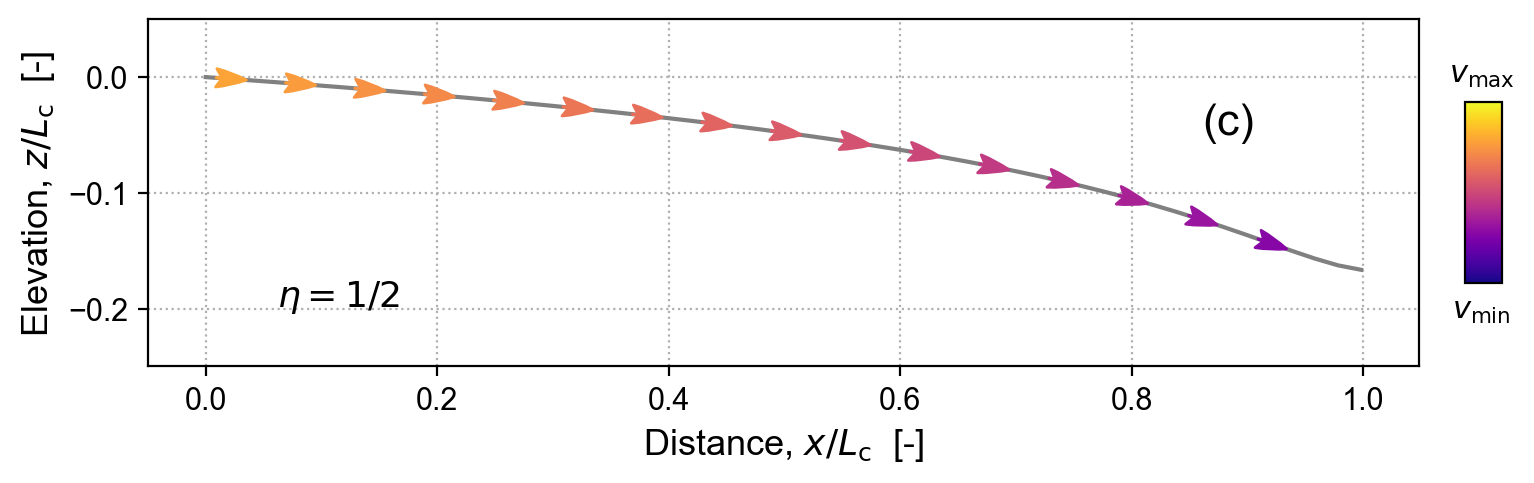

In [20]:
gr.profile_ray( gmes, gmeq, sub, job_name+'_ray_h_x', fig_size=(10,3), 
                   y_limits=pr.plot.ray_y_limits, 
                   n_points=pr.plot.ray_n_points,
                   eta_label_xy=pr.plot.ray_eta_xy, 
                   do_t_sampling=False,
                   do_pub_label=pr.plot.do_pub_labeling, 
                   pub_label=pr.plot.pub_labels['profile_h_ray'], 
                   pub_label_posn=pr.plot.pub_label_posns['profile_h_ray'])

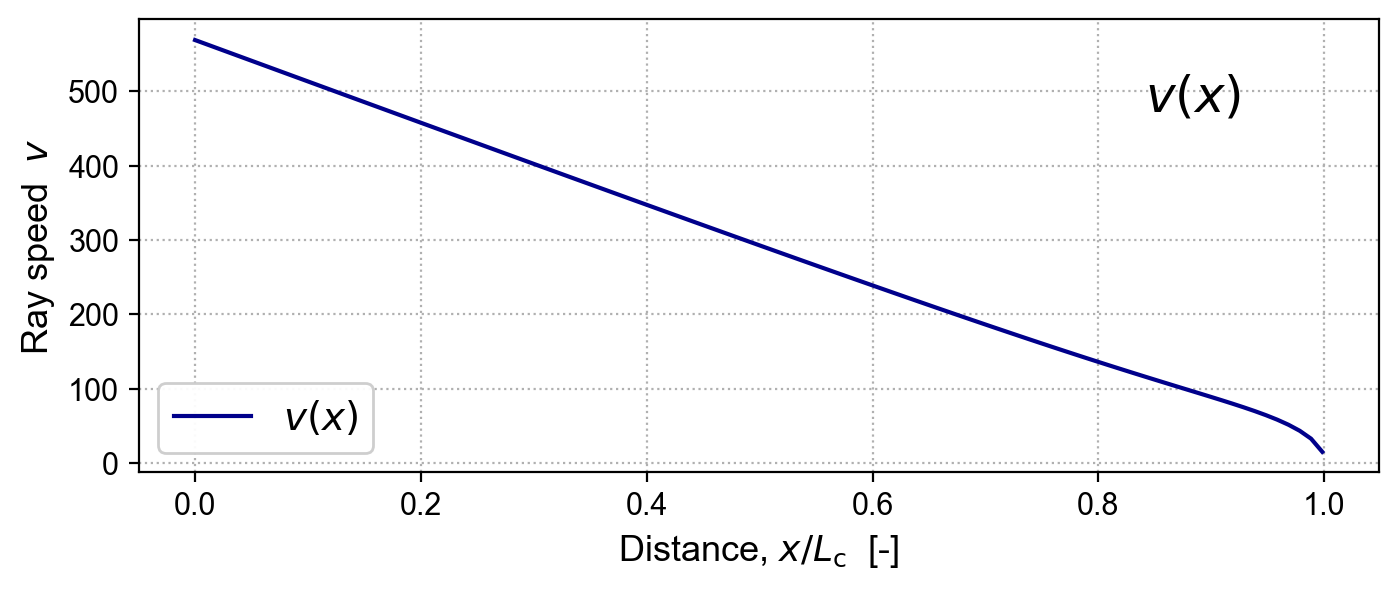

In [21]:
gr.profile_v( gmes, gmeq, sub, job_name+'_v_x', fig_size=(8,3), 
              n_points=pr.plot.profile_n_points,
              do_pub_label=pr.plot.do_pub_labeling, pub_label=pr.plot.pub_labels['profile_v'],
              do_mod_v=True, legend_loc='center left' )

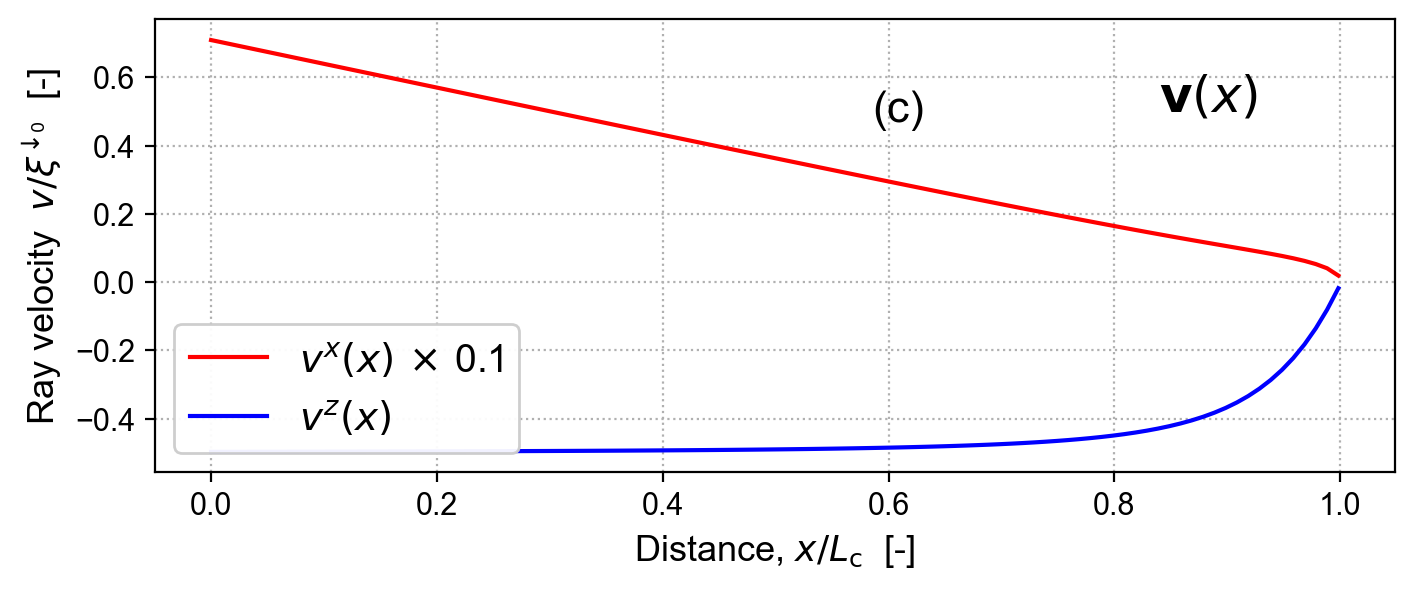

In [22]:
gr.profile_v( gmes, gmeq, sub, job_name+'_vxz_x', fig_size=(8,3), 
              n_points=pr.plot.profile_n_points,
              xi_norm=xiv_0.subs(sub), 
              do_pub_label=pr.plot.do_pub_labeling, pub_label=pr.plot.pub_labels['profile_vxz'],
              do_mod_v=False, legend_loc='lower left' )

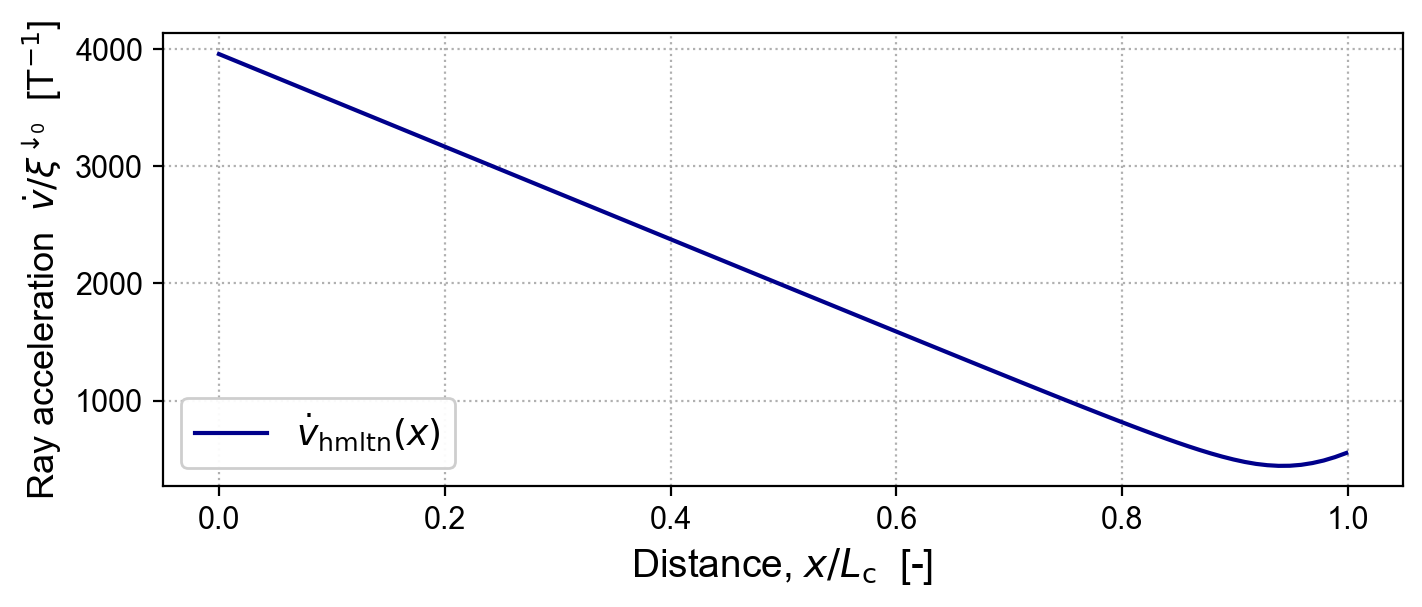

In [23]:
gr.profile_vdot( gmes, gmeq, sub, job_name+'_vdot_x', fig_size=(8,3), 
                 n_points=pr.plot.profile_n_points,
                 xi_norm=xiv_0.subs(sub), 
                 do_pub_label=pr.plot.do_pub_labeling, pub_label=pr.plot.pub_labels['profile_vdot'],
                 do_mod_vdot=True, do_geodesic=True )

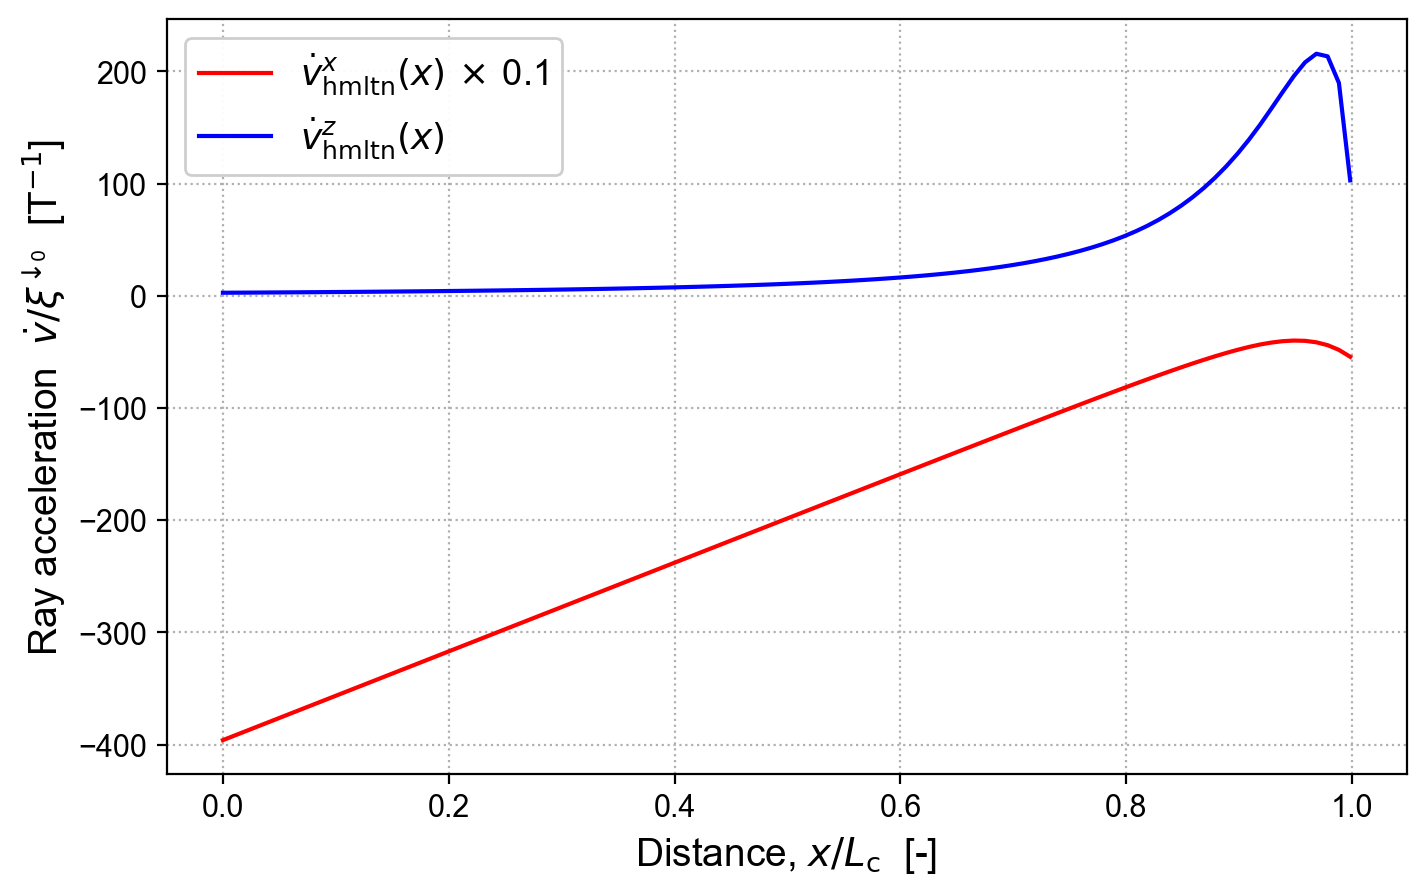

In [24]:
gr.profile_vdot( gmes, gmeq, sub, job_name+'_vdotxz_x', fig_size=(8,5), 
                 n_points=pr.plot.profile_n_points,
                 xi_norm=xiv_0.subs(sub), do_pub_label=pr.plot.do_pub_labeling, 
                 do_mod_vdot=False, 
                 legend_loc=pr.plot.ray_acceln_legend_loc, do_legend=True,
                 do_geodesic=True )

(Re)computing g matrices


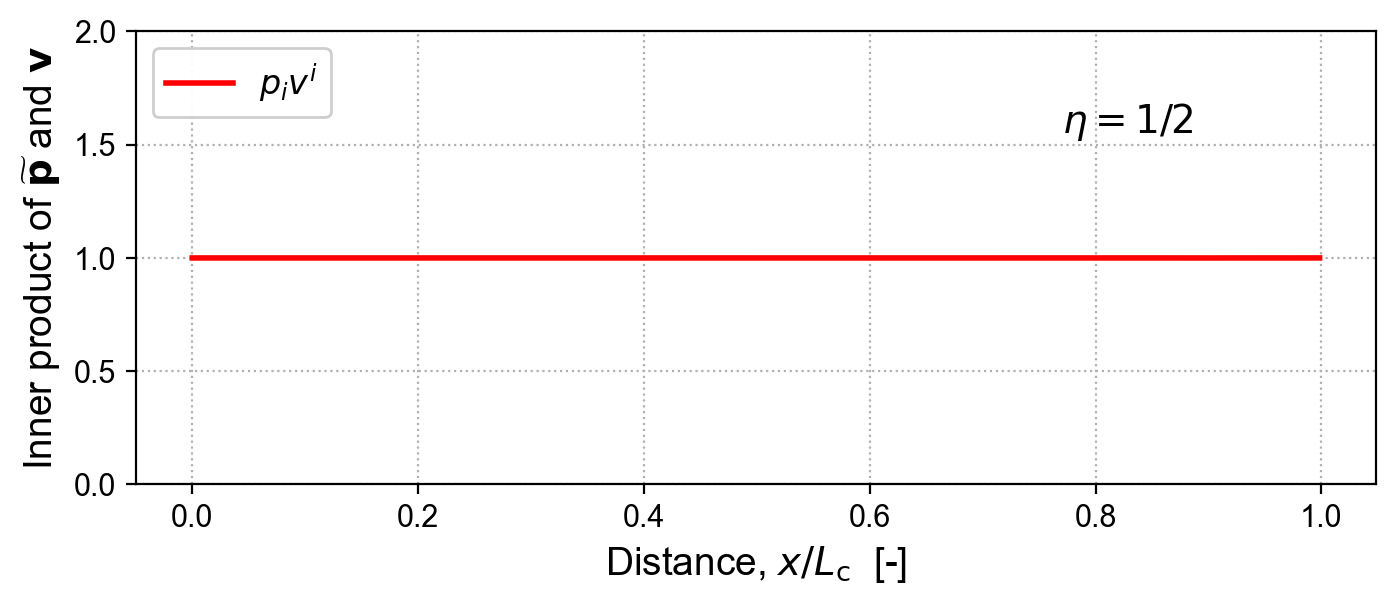

In [25]:
try:
    gr.profile_g_properties( gmes, gmeq, sub, job_name+'_pv', fig_size=(8,3), 
                         do_gstar=False, do_det=False, do_pv=True, legend_loc='center left', 
                         eta_label_xy=[0.8,0.8],
                         n_points=pr.plot.profile_ray_n_points )
except ValueError as error:
    print(error)

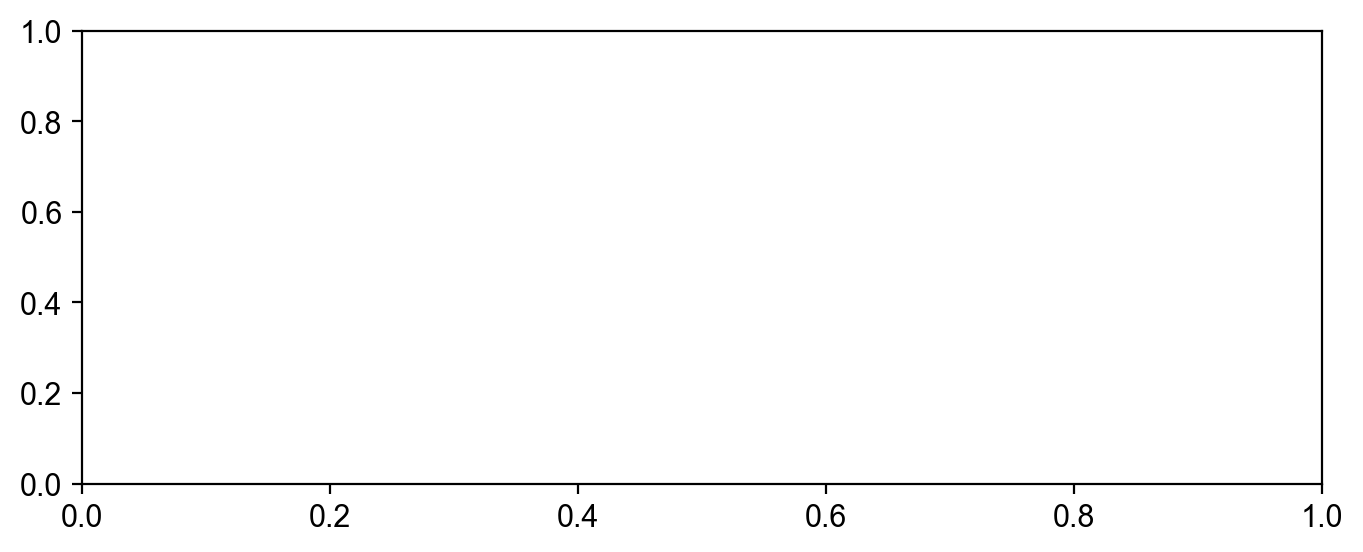

In [26]:
gr.profile_g_properties( gmes, gmeq, sub, job_name+'_det_gstar', fig_size=(8,3), 
                         do_gstar=True, do_det=True, legend_loc='center left', 
                         eta_label_xy=[0.7,0.7], 
                         n_points=pr.plot.profile_ray_n_points );

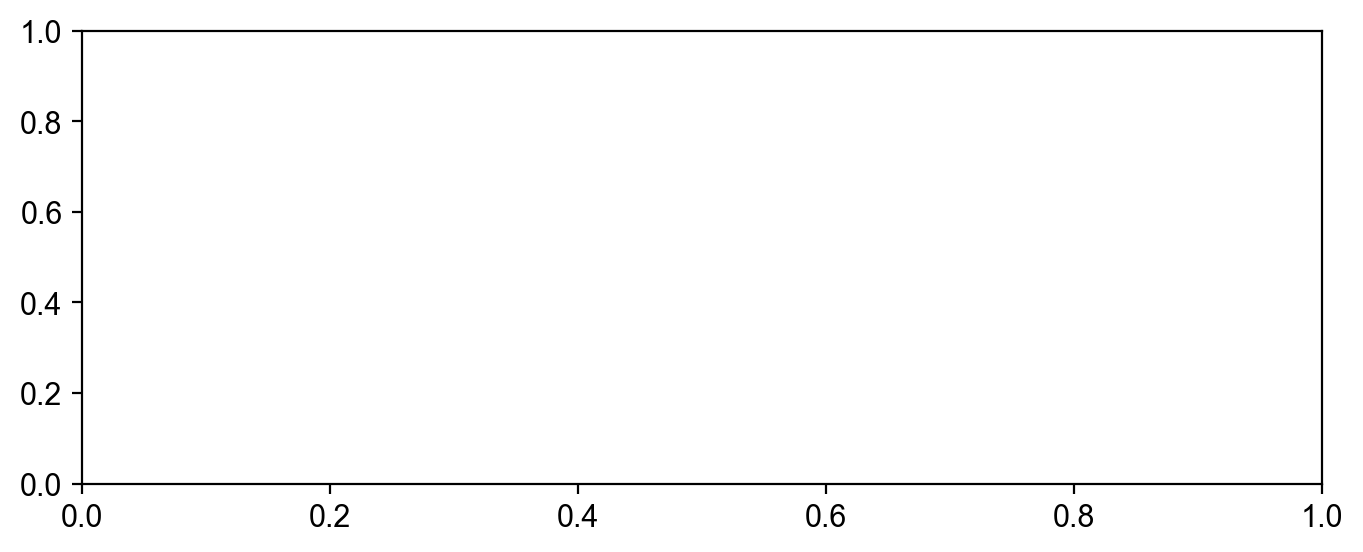

In [27]:
gr.profile_g_properties( gmes, gmeq, sub, job_name+'_gstar_eigenvalues', fig_size=(8,3), 
                         do_gstar=True, legend_loc='center left', 
                         eta_label_xy=pr.plot.profile_eval_eta_label_xy,
                         n_points=pr.plot.profile_ray_n_points )

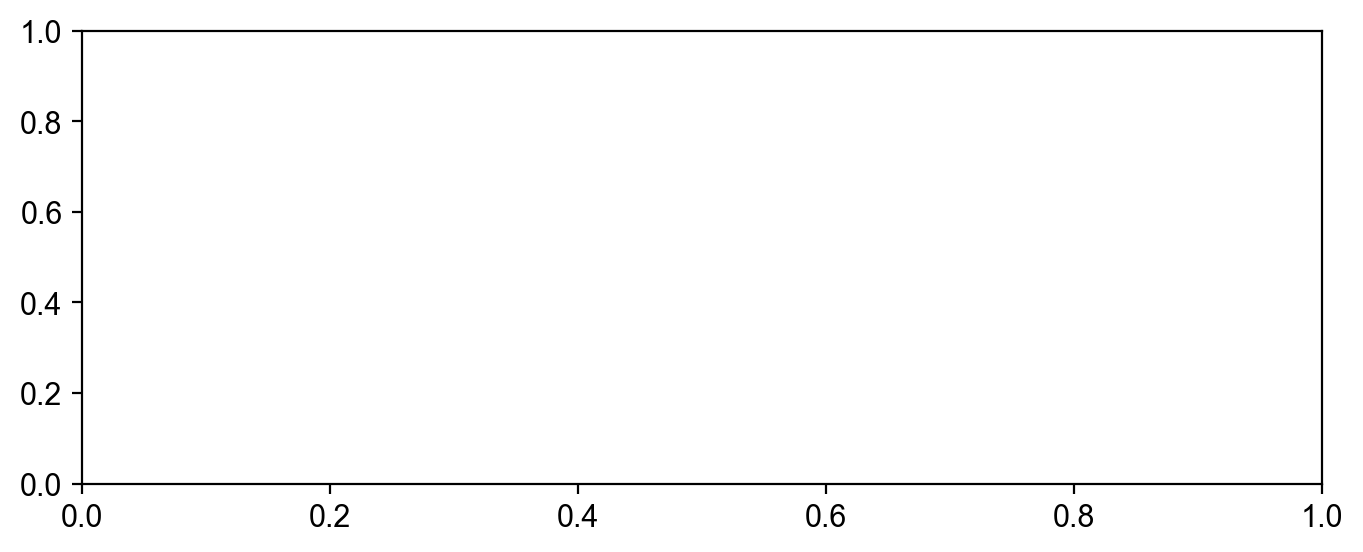

In [28]:
try:
    gr.profile_g_properties( gmes, gmeq, sub, job_name+'_det_g', fig_size=(8,3), 
                             do_gstar=False, do_det=True, legend_loc='center left', 
                             eta_label_xy=pr.plot.profile_det_eta_label_xy,
                             n_points=pr.plot.profile_ray_n_points )
except ValueError as error:
    print(error)

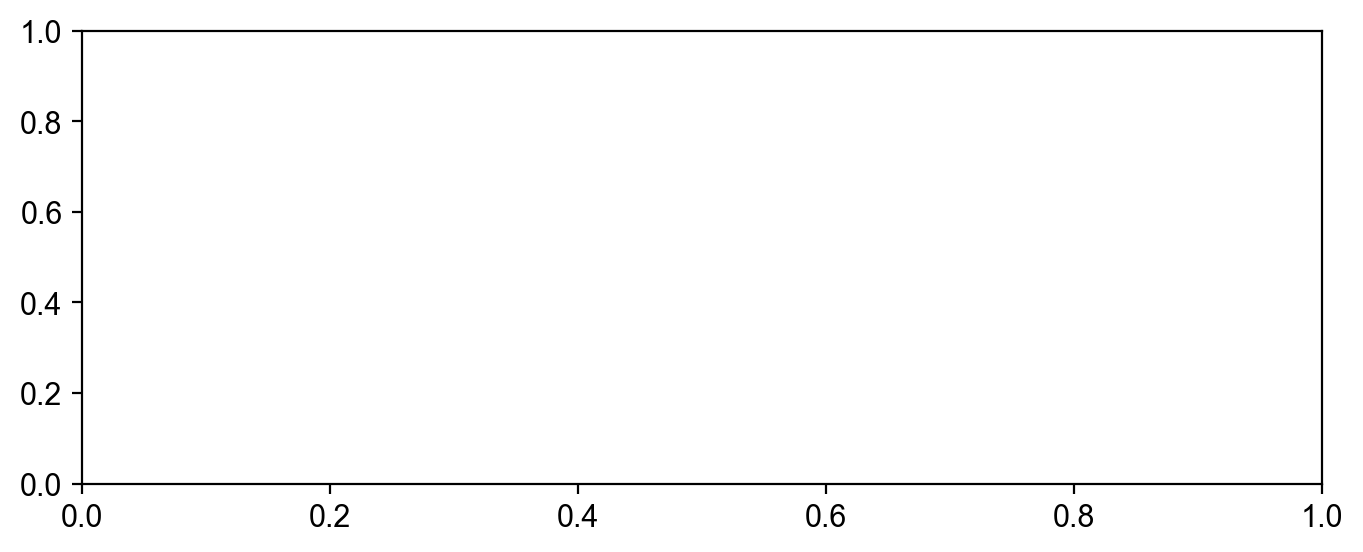

In [29]:
try:
    gr.profile_g_properties( gmes, gmeq, sub, job_name+'_g_eigenvalues', fig_size=(8,3), 
                             do_gstar=False, legend_loc='center left', 
                             eta_label_xy=pr.plot.profile_eval_eta_label_xy,
                             n_points=pr.plot.profile_ray_n_points )
except ValueError as error:
    print(error)

In [30]:
# try:
#     gr.profile_g_properties( gmes, gmeq, sub, job_name+'_g_eigenvectors', fig_size=(8,3), 
#                              y_limits=pr.plot.ray_y_limits, 
#                              do_gstar=False, do_eigenvectors=True, 
#                              legend_loc=pr.plot.profile_evec_legend_loc, 
#                              eta_label_xy=pr.plot.profile_evec_eta_label_xy,
#                              n_points=pr.plot.profile_ray_n_points )
# except ValueError as error:
#     print(error)

## Angles

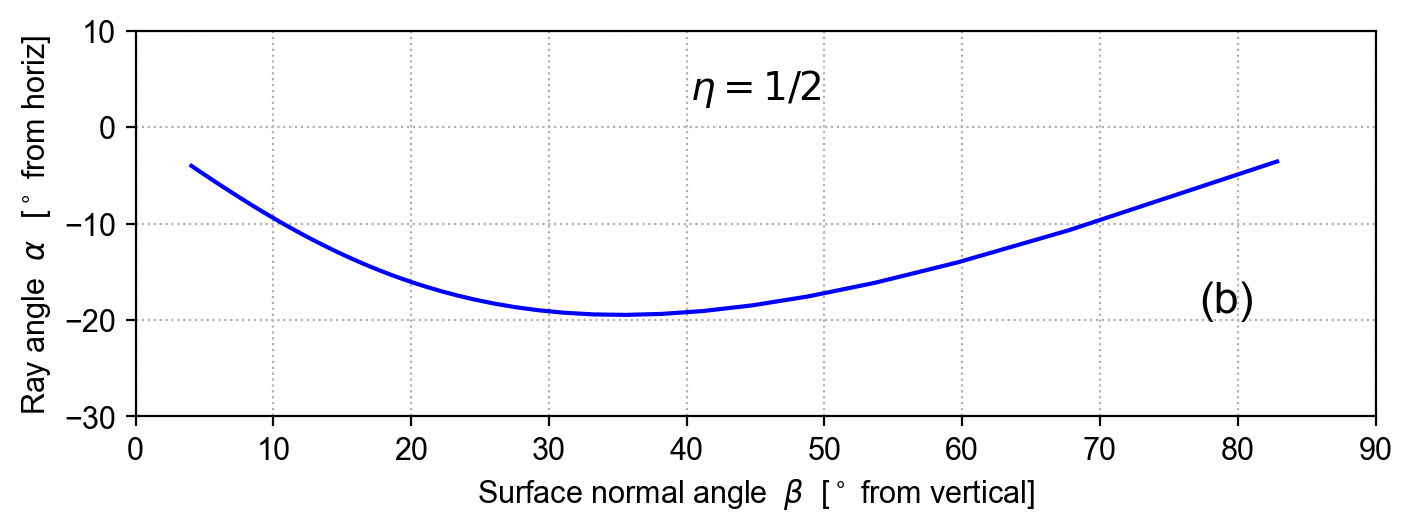

In [31]:
gr.alpha_beta( gmes, gmeq, sub, job_name+'_alpha_beta', fig_size=(8,6), 
               n_points=pr.plot.misc_n_points, do_legend=False, aspect=0.7,
               x_limits=pr.plot.ang_x_limits, y_limits=pr.plot.ang_y_limits,
               do_pub_label=pr.plot.do_pub_labeling, 
               pub_label=pr.plot.pub_labels['alpha_beta'], 
               pub_label_posn=pr.plot.pub_label_posns['alpha_beta'] )

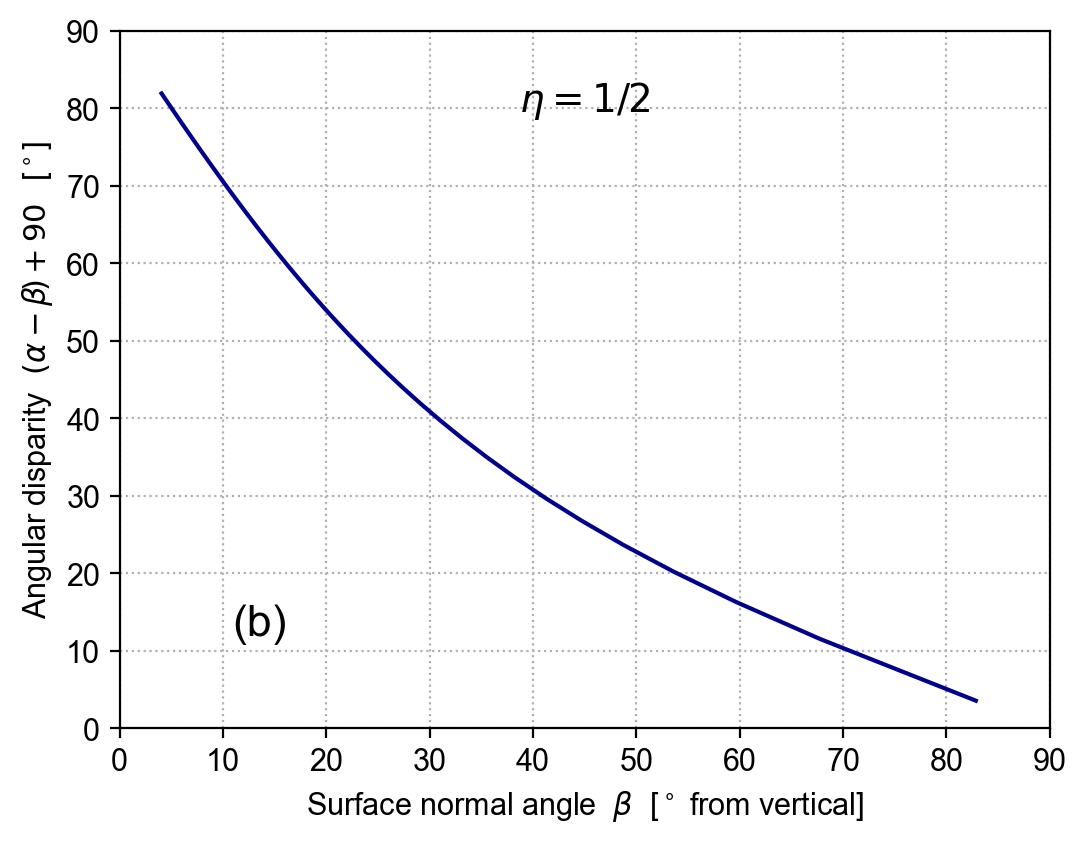

In [32]:
gr.angular_disparity( gmes, gmeq, sub, job_name+'_angular_disparity', fig_size=(6,6), 
                      n_points=pr.plot.misc_n_points, do_legend=False, aspect=0.75,
                      x_limits=pr.plot.angdisp_x_limits, y_limits=pr.plot.angdisp_y_limits,
                      do_pub_label=pr.plot.do_pub_labeling, 
                      pub_label=pr.plot.pub_labels['angular_disparity'], 
                      pub_label_posn=pr.plot.pub_label_posns['angular_disparity'] )

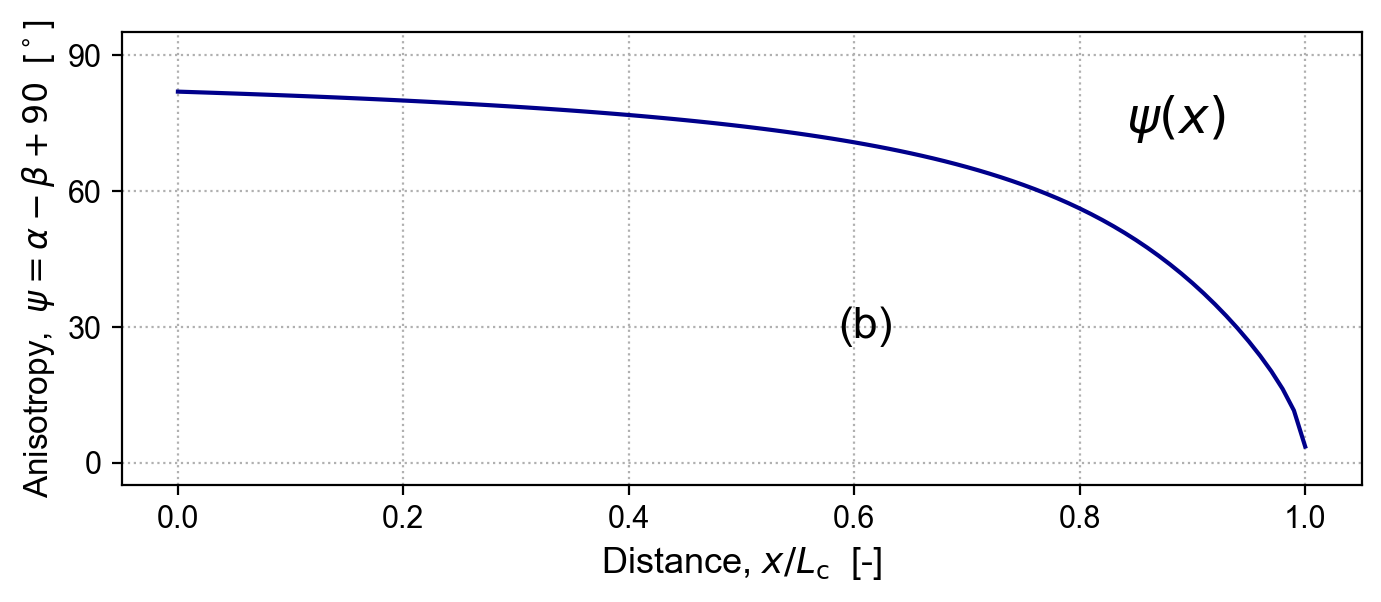

In [33]:
gr.profile_angular_disparity( gmes, gmeq, sub, job_name+'_angular_disparity_x',  fig_size=(8,3), 
                              n_points=pr.plot.profile_n_points,
                              do_pub_label=pr.plot.do_pub_labeling, 
                              pub_label=pr.plot.pub_labels['profile_angular_disparity'], 
                              pub_label_posn=pr.plot.pub_label_posns['profile_angular_disparity'] )

'OneRaySolution' object has no attribute 'px_value'


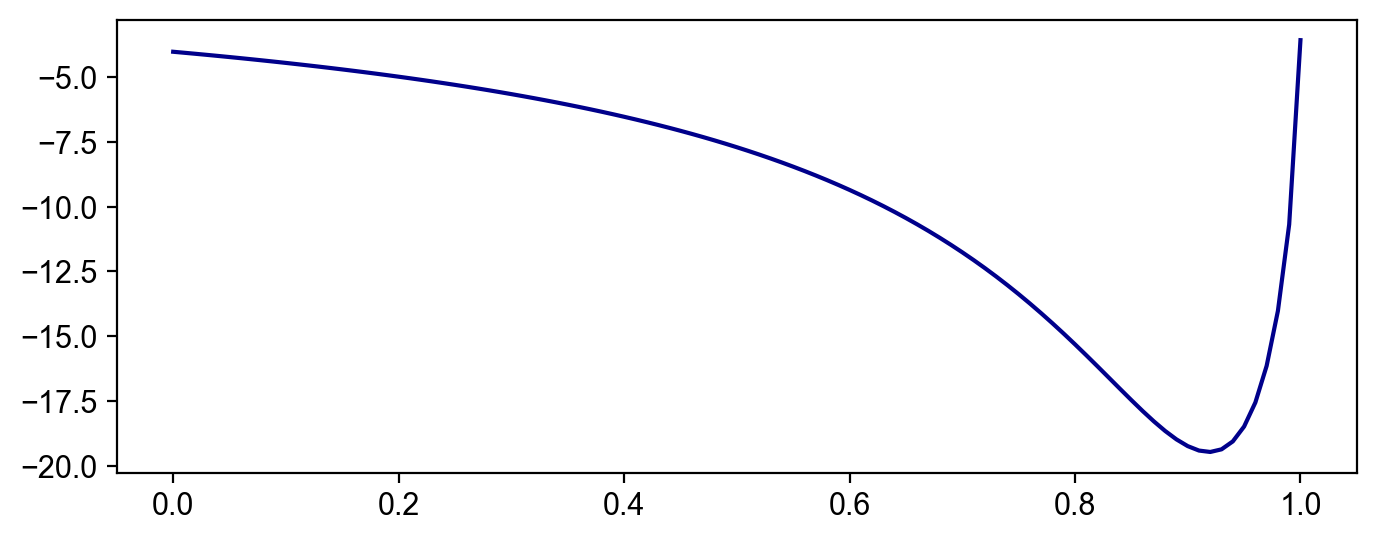

In [34]:
try:
    gr.profile_alpha( gmes, gmeq, sub, job_name+'_alpha_x', fig_size=(8,3), 
                  n_points=pr.plot.profile_n_points, do_legend=False )
except AttributeError as error:
    print(error)

# Save

Export the graphs as PNG and/or PDF image files.

In [35]:
plots_dir = create_directories(pr.save.figs_path, pr.job.group_name)
export_plots( gr.fdict, plots_dir, pr.save.figs_format, suffix='' )

Writing to dir: "/Users/colinstark/Projects/GME/Plots/OneRaySolutions"
Exported "oneray_sinbeta_ramp_eta0p5_ratio0p5_xiv80_ray_h_x.png"
Exported "oneray_sinbeta_ramp_eta0p5_ratio0p5_xiv80_v_x.png"
Exported "oneray_sinbeta_ramp_eta0p5_ratio0p5_xiv80_vxz_x.png"
Exported "oneray_sinbeta_ramp_eta0p5_ratio0p5_xiv80_vdot_x.png"
Exported "oneray_sinbeta_ramp_eta0p5_ratio0p5_xiv80_vdotxz_x.png"
Exported "oneray_sinbeta_ramp_eta0p5_ratio0p5_xiv80_pv.png"
Exported "oneray_sinbeta_ramp_eta0p5_ratio0p5_xiv80_det_gstar.png"
Exported "oneray_sinbeta_ramp_eta0p5_ratio0p5_xiv80_gstar_eigenvalues.png"
Exported "oneray_sinbeta_ramp_eta0p5_ratio0p5_xiv80_det_g.png"
Exported "oneray_sinbeta_ramp_eta0p5_ratio0p5_xiv80_g_eigenvalues.png"
Exported "oneray_sinbeta_ramp_eta0p5_ratio0p5_xiv80_alpha_beta.png"
Exported "oneray_sinbeta_ramp_eta0p5_ratio0p5_xiv80_angular_disparity.png"
Exported "oneray_sinbeta_ramp_eta0p5_ratio0p5_xiv80_angular_disparity_x.png"
Exported "oneray_sinbeta_ramp_eta0p5_ratio0p5_xiv80_al